In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from script import *

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing

In [4]:
pd.set_option('display.max_columns', None) 

In [5]:
df_meta_physical = pickle.load(open('pickle_files/df_meta_physical.p','rb'))

In [6]:
#add number of floors as feature
second_floors = df_meta_physical[df_meta_physical.second_floor_square_footage > 0]
third_floors = df_meta_physical[df_meta_physical.third_floor_square_footage > 0]
df_meta_physical.loc[:, 'Floors'] = 1
df_meta_physical.loc[second_floors.index, 'Floors'] = 2
df_meta_physical.loc[third_floors.index, 'Floors'] = 3

In [7]:
df_regression = df_meta_physical.loc[:,['dataid','building_type_x','pv_x','house_construction_year_x', 'total_square_footage_x', 'Floors']]
df_regression.index = df_regression['dataid']

## Add energy usage as target

In [8]:
from datetime import datetime, timedelta

In [9]:
df_meta_refined = pickle.load(open('pickle_files/df_meta_refined.p', 'rb'))

In [10]:
#function to calculate total energy usage for time period
def calculate_energy_usage(dataid, final_date=None, length=30):
    
    start, end = find_egauge_dates(dataid, length, final_date)
    df = pickle.load(open('pickle_files/df_{}.p'.format(dataid), 'rb'))
    
    df.index = df.apply(strip_tz, axis=1)
    
    energy_usage = sum(df.loc[str(start):str(end), 'use'])
#     energy_usage = sum(df.loc[start:end, 'use'])
    
    return energy_usage

In [11]:
df_8047 = pickle.load(open('pickle_files/df_8047.p', 'rb'))
df_8047.index = df_8047['localhour']

In [12]:
calculate_energy_usage(8047)

263.33581666666623

In [ ]:
#remove buildings with insufficient data
df_regression = df_regression[df_regression.Energy_Usage > 0]

## Modify features

In [ ]:
#add building age column
df_regression.loc[:,'Building_Age'] = 2017 - df_regression.loc[:,'house_construction_year_x']

In [ ]:
#make dummy variables for PV
df_regression['pv_x'].replace(to_replace= 'yes', value=1, inplace=True)
df_regression['pv_x'].replace(to_replace=np.nan, value=0, inplace=True)

In [ ]:
#make dummy variables for building type
df_regression = df_regression.join(pd.get_dummies(df_regression.building_type_x))

In [ ]:
#Rename columns
df_regression.rename(columns={'building_type_x':'Building_Type', 'pv_x':'PV', 'house_construction_year_x':'Construction_Year',
                             'total_square_footage_x': 'Total_Square_Footage', 'Single-Family Home': 'Single_Family_Home',
                             'Town Home': 'Town_Home'}, inplace=True)

In [ ]:
df_regression.head()

In [15]:
# pickle.dump(df_regression, open('pickle_files/df_regression.p', 'wb'))
df_regression = pickle.load(open('pickle_files/df_regression.p', 'rb'))

## Build regression models

### Linear Regression

In [16]:
lr_model = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=910)
y = df_regression['Energy_Usage']
X = df_regression.drop(['dataid','Building_Type','Construction_Year','Energy_Usage', 'Town_Home'], axis=1)

In [17]:
df_regression_new = pd.DataFrame(y)
df_regression_new = df_regression_new.join(X)

In [18]:
scores = cross_val_score(lr_model, X, y, cv=cross_valiator)
np.mean(scores)

0.29753579781481088

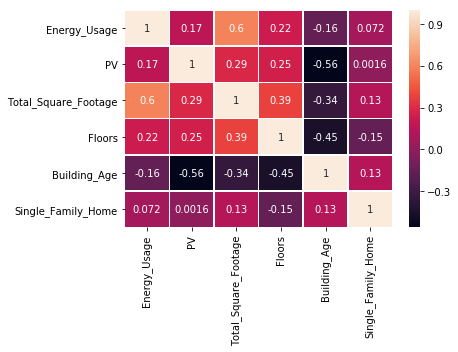

In [19]:
sns.heatmap(df_regression_new.corr(),annot=True,linewidth=0.5)

In [20]:
lr_model2 = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=910)
y = df_regression['Energy_Usage']
X = df_regression.drop(['dataid','Building_Type','Construction_Year','Energy_Usage', 'Single_Family_Home','Town_Home'], axis=1)

In [21]:
scores = cross_val_score(lr_model2, X, y, cv=cross_valiator)
np.mean(scores)

0.30244424171719303

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=2, random_state=0)
rf_model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
scores = cross_val_score(rf_model, X, y, cv=cross_valiator)
np.mean(scores)

0.30855695890357021

Regression models have pretty low R-squared scores...

In [25]:
rf_model.predict([[0,2000,1,15]])

array([ 868.27756396])

### KNN

In [26]:
from sklearn.neighbors import KNeighborsRegressor

In [27]:
parameters = {'n_neighbors':range(2,100),'weights':['uniform','distance']}
knn_model = KNeighborsRegressor()
clf = GridSearchCV(knn_model, parameters, cv=5)
clf.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': range(2, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [28]:
clf.best_params_

{'n_neighbors': 27, 'weights': 'uniform'}

In [29]:
knn_model = KNeighborsRegressor(n_neighbors=27, weights='uniform')
knn_model.fit(X,y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=27, p=2,
          weights='uniform')

In [30]:
scores = cross_val_score(knn_model, X, y, cv=cross_valiator)
np.mean(scores)

0.26819722438735949

In [31]:
X.head()

,PV,Total_Square_Footage,Floors,Building_Age
dataid,,,,
1464,1.0,2345.0,2,10.0
8047,1.0,3245.0,2,8.0
8597,1.0,2122.0,2,9.0
7982,1.0,1720.0,1,10.0
7057,0.0,1720.0,1,8.0


In [32]:
#function to predict monthly energy usage for building
def predict_energy_usage(dataid, model):
    
    features = df_regression.loc[dataid,:]
    predicted = model.predict([[features.PV, features.Total_Square_Footage, features.Floors, features.Building_Age]])[0]
    actual = features.Energy_Usage
    
    return predicted, actual

In [37]:
predict_energy_usage(df_regression.index[100], rf_model)

(691.35890440658591, 409.89418333333344)

In [39]:
predict_energy_usage(545, rf_model)

(1015.9825477102916, 1182.0193000000006)

In [38]:
df_regression.loc[1464,:]

dataid                                1464
Building_Type           Single-Family Home
PV                                       1
Construction_Year                     2007
Total_Square_Footage                  2345
Floors                                   2
Energy_Usage                       959.663
Building_Age                            10
Single_Family_Home                       1
Town_Home                                0
Name: 1464, dtype: object

In [48]:
df_meta_refined = df_meta_refined.merge(df_regression, how='inner', on='dataid')
df_meta_refined

,dataid,active_record,building_type,program_579,program_baseline,program_energy_internet_demo,program_lg_appliance,program_verizon,program_ccet_group,program_civita_group,city,state,pv,date_enrolled,date_withdrawn,house_construction_year,total_square_footage,first_floor_square_footage,second_floor_square_footage,third_floor_square_footage,half_floor_square_footage,lower_level_square_footage,audit_2011,audit_2013_2014,survey_2011,survey_2012,survey_2013,survey_2014,number_of_nests,indoor_temp_min_time,indoor_temp_max_time,gas_ert_min_time,gas_ert_max_time,water_ert_min_time,water_ert_max_time,egauge_min_time,egauge_max_time,use,grid,gen,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,bedroom2,bedroom3,bedroom4,bedroom5,car1,clotheswasher1,clotheswasher_dryg1,diningroom1,diningroom2,dishwasher1,disposal1,drye1,dryg1,freezer1,furnace1,furnace2,garage1,garage2,heater1,housefan1,icemaker1,jacuzzi1,kitchen1,kitchen2,kitchenapp1,kitchenapp2,lights_plugs1,lights_plugs2,lights_plugs3,lights_plugs4,lights_plugs5,lights_plugs6,livingroom1,livingroom2,microwave1,office1,outsidelights_plugs1,outsidelights_plugs2,oven1,oven2,pool1,pool2,poollight1,poolpump1,pump1,range1,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1,Building_Type,PV,Construction_Year,Total_Square_Footage,Floors,Energy_Usage,Building_Age,Single_Family_Home,Town_Home
0,1464,None,Single-Family Home,None,yes,yes,None,None,CCET - Control,None,Austin,Texas,yes,2011-02-01,2014-03-06,2007.0,2345.0,1385.0,960.0,0.0,NaN,NaN,yes,,yes,yes,,,NaN,None,None,2012-04-13 09:26:26-05:00,2014-02-06 23:53:33-06:00,2012-05-01 13:00:00-05:00,2014-02-06 23:58:03-06:00,2012-10-19 19:00:00-05:00,2014-03-05 17:59:00-06:00,yes,yes,yes,yes,None,None,None,None,None,None,yes,yes,yes,None,None,None,yes,None,None,None,yes,yes,None,yes,None,None,None,None,None,None,None,None,None,None,None,yes,None,yes,None,None,None,None,None,None,None,yes,None,None,None,yes,None,None,None,None,None,None,yes,yes,None,yes,None,yes,None,None,None,None,None,Single-Family Home,1.0,2007.0,2345.0,2,959.662583,10.0,1,0
1,8047,None,Single-Family Home,None,yes,yes,None,None,CCET - Pricing Trial,None,Austin,Texas,yes,2011-02-01,2014-04-07,2009.0,3245.0,1779.0,1466.0,0.0,NaN,NaN,yes,,yes,,yes,,NaN,None,None,2012-04-11 18:59:52-05:00,2013-05-10 16:26:10-05:00,None,None,2013-04-16 00:00:00-05:00,2014-04-07 00:00:00-05:00,yes,yes,yes,yes,None,None,None,None,yes,None,None,None,None,None,None,None,yes,None,None,None,yes,yes,None,yes,yes,yes,None,None,None,None,None,None,None,None,None,yes,yes,None,None,None,None,None,None,None,None,yes,None,None,None,yes,None,None,None,None,None,None,None,yes,None,None,None,None,None,yes,None,None,None,Single-Family Home,1.0,2009.0,3245.0,2,263.335817,8.0,1,0
2,8597,None,Single-Family Home,None,yes,yes,None,None,CCET - UT Text,None,Austin,Texas,yes,2011-02-01,2014-10-31,2008.0,2122.0,1162.0,960.0,0.0,NaN,NaN,yes,,yes,,,,NaN,None,None,2012-04-11 18:59:53-05:00,2013-05-10 16:28:22-05:00,None,None,2012-10-26 19:00:00-05:00,2014-10-21 18:59:00-05:00,yes,yes,yes,yes,None,None,None,None,None,None,yes,None,None,None,None,None,yes,None,yes,None,yes,yes,yes,None,None,yes,None,None,None,None,None,None,None,None,None,yes,yes,yes,yes,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,yes,yes,None,None,None,None,None,None,None,None,None,Single-Family Home,1.0,2008.0,2122.0,2,1198.043117,9.0,1,0
3,7982,None,Single-Family Home,None,yes,yes,yes,None,CCET - Pricing Trial,None,Austin,Texas,yes,2011-02-01,2014-11-15,2007.0,1720.0,1720.0,0.0,0.0,NaN,NaN,yes,yes,yes,,yes,,NaN,2014-02-21 11:04:54-06:00,2014-11-14 14:59:01-06:00,2012-04-11 18:59:57-05:00,2014-11-14 23:59:42-06:00,2012-05-01 13:00:00-05:00,2014-11-14 23:56:22.783059-06:00,2013-02-22 18:00:00-06:00,2014-11-13 17:59:00-06:00,yes,yes,yes,yes,None,None,None,None,None,None,yes,None,None,None,None,yes,yes,None,yes,None,yes,yes,yes,yes,None,yes,Non